In [1]:
# Jupyter notebook 경고 메시지 숨기기
from warnings import filterwarnings
filterwarnings(action="ignore")

# 4. 모델 훈련

## 4.1 선형 회귀
선형 모델은 아래 식처럼 입력 특성의 가중치 합와 편향<small>bias</small>이라는 상수를 이용해 만든다.

$$ \widehat{y}=\theta_0 + \theta_1x_1 + \theta_2x_2 + \cdots + \theta_nx_n $$

- $y$는 예측값이다.
- $n$은 특성의 수이다.
- $x_i$는 $i$번째 특성의 값이다.
- $\theta_i$는 $i$번째 모델 파라미터이다. 편향 $\theta_0$과 특성의 가중치 $\theta_1, \theta_2, \cdots, \theta_n$이 있다.

이를 간단히 아래처럼 만들 수 있다.

$$ \widehat{y} = h_\theta(X) = \theta \cdot X $$

모델을 훈련시킨다는 것은 모델이 훈련 세트에 맞도록 파라미터를 변경한다는 것이다.
이를 위해서는 모델이 훈련 데이터에 얼마나 잘 맞는지 평가해야 한다.
성능 측정 지표 중 하나인 평균 제곱 오차(MSE)는 다음과 같다.

$$ \mathrm{MSE}(X, h_\theta)=\frac{1}{m} \sum_{i=1}^{m} (\theta^T\mathrm{x}^{(i)}-y^{(i)})^2 $$

### 4.1.1 정규방정식
비용 함수를 최소화할 수 있는 $\theta$값을 바로 찾을 수 있는 수식이 있다. 이를 **정규방정식**이라고 한다.

$$ \widehat{\theta} = (X^TX)^{-1}X^Ty $$

- $\widehat{\theta}$는 비용 함수를 최소화하는 $\theta$값이다.
- $y$는 $y^{(1)}$부터 $y^{(m)}$까지를 포함하는 벡터이다.

이 공식을 테스트해 보자.

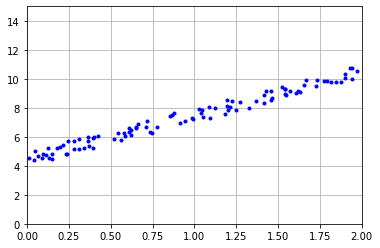

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.rand(100, 1)

# 그래프 그리기
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.grid(True)
plt.show()

In [3]:
X_b = np.c_[np.ones((100, 1)), X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[4.51359766],
       [2.98323418]])

모델의 예측을 그래프로 나타내 보자.

In [4]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 4.51359766],
       [10.48006601]])

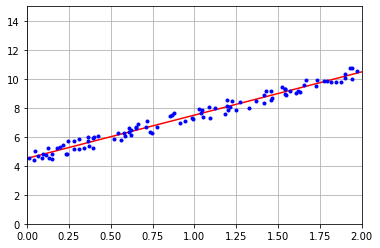

In [5]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.grid(True)
plt.show()

반면 사이킷런에서 선형 회귀를 수행하는 것은 간단하다.

In [6]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.51359766]), array([[2.98323418]]))

In [7]:
lin_reg.predict(X_new)

array([[ 4.51359766],
       [10.48006601]])

### 4.1.2 계산 복잡도
정규방정식은 크기가 $ (n+1) \times (n+1) $인 $ X^TX $의 역행렬을 계산한다.
이를 계산하는 복잡도는 일반적으로 $ O(n^{2.4}) $에서 $ O(n^3) $사이이다.

사이킷런의 `LinearRegression` 클래스가 사용하는 방법은 약 $ O(n^2) $의 복잡도를 가진다.

선형 회귀 모델은 예측이 매우 빠르다. 예측 계산의 복잡도는 샘플 수와 특성 수에 선형적이다.

## 4.2 경사 하강법

### 4.2.1 배치 경사 하강법
경사 하강법을 구현하려면 $\theta_j$가 조금 바뀌었을때 비용 함수가 얼마나 바뀌는지를 계산해야 한다.
이를 **편도함수**라고 한다. 아래 식은 파라미터 $\theta_j$에 대한 비용 함수의 편도함수이다.

$$ \frac{\partial}{\partial \theta_j}\mathrm{MSE}(\theta) = \frac{2}{m} \sum_{i=1}^m (\theta^T\mathrm{x}^{(i)}-y^{(i)})x_j^{(i)} $$

편도함수를 각각 계산하는 대신 아래 식을 사용하면 한꺼번에 계산할 수 있다.

$$\nabla_\theta\mathrm{MSE}(\theta) = \begin{pmatrix} \frac{\partial}{\partial \theta_0}\mathrm{MSE}(\theta) \\ \frac{\partial}{\partial \theta_1}\mathrm{MSE}(\theta) \\ \vdots \\ \frac{\partial}{\partial \theta_n}\mathrm{MSE}(\theta) \end{pmatrix} = \frac{2}{m}X^T(X\theta - y) $$

위로 향하는 그레디언트 벡터가 구해지면 반대 방향으로 내려가야 한다. 여기서 학습률 $\eta$가 사용된다.

$$ \theta^{(\text{next step})}=\theta-\eta\nabla_\theta\mathrm{MSE}(\theta) $$

In [8]:
eta = 0.1   # 학습률
n_iterations = 1000
m = 100
theta_path_bgd = []

theta = np.random.randn(2, 1)

for iteration in range(n_iterations):
    gradients = 2 / m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients
    theta_path_bgd.append(theta)

theta

array([[4.51359766],
       [2.98323418]])

만약 학습률이 너무 작거나 크다면 어떻게 될까?

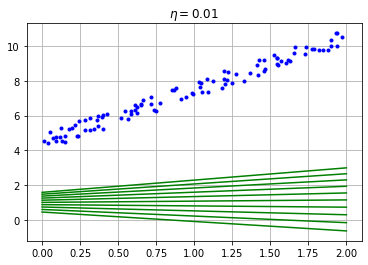

In [9]:
plt.plot(X, y, "b.")
plt.grid(True)
plt.title(r"$\eta = 0.01$")

eta = 0.01  # 학습률
n_iterations = 1000
m = 100

theta = np.random.randn(2, 1)

for iteration in range(n_iterations):
    gradients = 2 / m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients
    if iteration < 10:
        y_predict = X_new_b.dot(theta)
        plt.plot(X_new, y_predict, "g-")

학습률이 너무 낮은 경우에는 최저점에 도달은 하겠지만 시간이 너무 오래 걸릴 것이다.

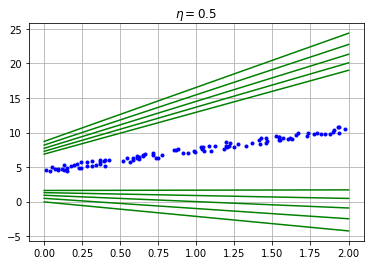

In [10]:
plt.plot(X, y, "b.")
plt.grid(True)
plt.title(r"$\eta = 0.5$")

eta = 0.5  # 학습률
n_iterations = 1000
m = 100

theta = np.random.randn(2, 1)

for iteration in range(n_iterations):
    gradients = 2 / m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients
    if iteration < 10:
        y_predict = X_new_b.dot(theta)
        plt.plot(X_new, y_predict, "g-")

학습률이 너무 높은 경우에는 최저점을 찾지 못하고 발산하게 될 것이다.

### 4.2.2 확률적 경사 하강법
배치 경사 하강법의 문제는 매 스텝에서 전체 훈련 세트를 이용해 그래디언트를 계산한다는 것이다.
훈련 세트가 커지면 매우 느려지게 된다.

이와는 반대로 **확률적 경사 하강법**은 매 스텝에서 한 개의 샘플을 무작위로 선택하고
그 하나의 샘플에 대한 그라디언트를 계산한다. 적은 수의 샘플을 다루기 때문에 배치 경사 하강법보다 빠르다.

반면 무작위이므로 배치 경사 하강법에 비해 불안정하게 된다. 비용 함수가 최솟값에 다가갈 동안
부드럽게 감소하지 않고 무작위로 요동치게 된다. 알고리즘이 멈출 때의 값이 최적치인지 확신할 수 없다.

무작위성은 지역 최솟값에서 탈출할 수 있게 해 주지만 전역 최솟값에 도달하지 못하게 한다는 점에서 좋지 않다.
이를 해결하는 한 가지 방법은 학습률을 점진적으로 감소시키는 것이다.

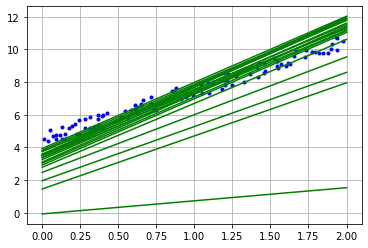

확률적 경사 하강법의 첫 20스텝


In [11]:
plt.grid(True)
plt.plot(X, y, "b.")

def learning_schedule(t):
    t0, t1 = 5, 50
    return t0 / (t + t1)

n_epochs = 50
theta = np.random.randn(2, 1)
m = len(X_b)
theta_path_sgd = []

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index : random_index + 1]
        yi = y[random_index : random_index + 1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)
        if epoch == 0 and i < 20:
            y_predict = X_new_b.dot(theta)
            plt.plot(X_new, y_predict, "g-")

plt.show()
print("확률적 경사 하강법의 첫 20스텝")

In [12]:
theta

array([[4.5170222 ],
       [2.98424055]])

사이킷런에서 SGD 방식으로 선형 회귀를 사용하려면 `SGDRegressor`클래스를 사용한다.
아래 코드는 최대 1000 epoch, 또는 한 epoch에서 0.001보다 손실이 적게 줄어들 때까지 실행된다. 학습률은 0.1이다.

In [13]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, eta0=0.1, penalty=None)
sgd_reg.fit(X, y.ravel())

sgd_reg.intercept_, sgd_reg.coef_

(array([4.4928448]), array([2.99219226]))

### 4.2.3 미니배치 경사 하강법
**미니배치 경사 하강법**은 미니배치라 부르는 임의의 샘플 세트에 대해 그레디언트를 계산한다.
미니배치의 크기를 크게 할수록 SGD보다 덜 불규칙적으로 움직인다.

In [14]:
theta_path_mgd = []
n_iterations = 50
minibatch_size = 20
t = 0
theta = np.random.randn(2, 1)

def learning_schedule(t):
    t0, t1 = 200, 1000
    return t0 / (t + t1)

for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

theta

array([[4.55697515],
       [3.02703615]])

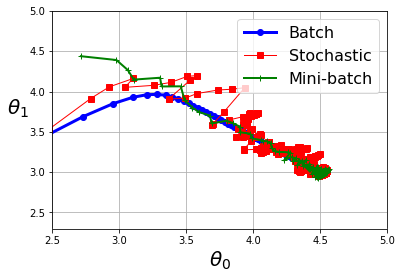

경사 하강법의 경로


In [15]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")

plt.legend(loc="upper right", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 5.0, 2.3, 5.0])
plt.grid(True)
plt.show()
print("경사 하강법의 경로")

## 4.3 다항 회귀
비선형 데이터를 학습시키는데 선형 모델을 사용할 수 있다.

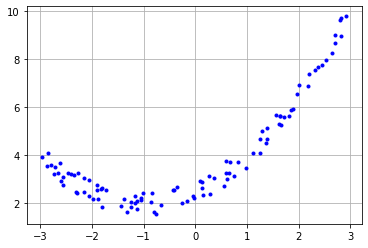

In [16]:
np.random.seed(42)

m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * (X ** 2) + X + 2+  np.random.rand(m, 1)

plt.plot(X, y, "b.")
plt.grid(True)
plt.show()

In [17]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0], X_poly[0]

(array([-0.75275929]), array([-0.75275929,  0.56664654]))

In [18]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([2.49786712]), array([[0.9943591 , 0.49967213]]))

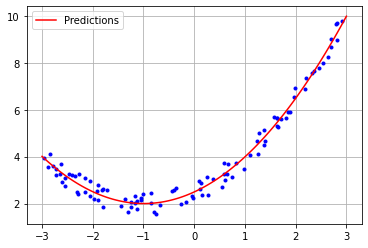

In [19]:
X_new = np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)

plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", label="Predictions")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

원래 함수가 $ y=0.5x^2+x+2 $였다면 예측한 모델은 $ \hat{y}=0.49x^2+0.99x+2.49 $이다.

## 4.4 학습 곡선
고차 다항 회귀를 사용하면 보통의 선형 회귀보다 훨씬 더 데이터에 잘 맞추려고 할 것이다.
다음 그래프는 이전의 데이터에 300차 다항 회귀 모델을 적용한 것이다.

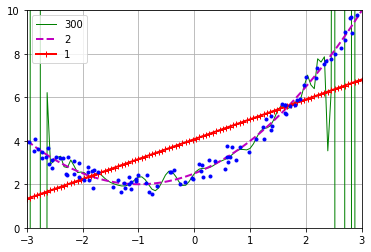

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in [("g-", 1, 300), ("m--", 2, 2), ("r-+", 2, 1)]:
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
        ("poly_features", polybig_features),
        ("std_scaler", std_scaler),
        ("lin_reg", lin_reg)
    ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.")
plt.legend(loc="upper left")
plt.axis([-3, 3, 0, 10])
plt.grid(True)
plt.show()

300차 다항식 모델은 훈련 데이터에 과대적합되었다. 반명 선형 모델은 과소적합이다.

위 데이터는 2차방정식으로 생성된 것이기 때문에 2차 다항식 모델이 적합하다는 것을 알 수 있지만,
대부분의 경우 어떤 함수를 이용해 생성되었는지는 알 수 없다. 그렇다면 어떤 모델을 사용해야 할지를 어떻게 알 수 있을까?

이전에는 모델의 일반화 성능을 추정하기 위해 교차 검증을 사용했다.
훈련 데이터에서 사용되었지만 교차 검증 점수가 나쁘다면 모델이 과대적합된 것이다. 만약 양쪽에서 모두 좋지 않다면 과소적합이다.

또 다른 방법은 **학습 곡선**을 살펴 보는 것이다. 이 곡선은 훈련 세트와 검증 세트의 모델 성능을 훈련 세트 크기의 함수로 나타낸다.
이 그래프를 생성하기 위해서는 단순히 훈련 세트에서 크기가 다른 서브 세트를 만들어 모델을 여러 번 훈련시키기만 하면 된다.


In [21]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_error, val_error = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_error.append(mean_squared_error(y_train[:m], y_train_predict))
        val_error.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_error), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_error), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right")
    plt.grid(True)

다음은 단순한 선형 회귀 모델의 학습 곡선이다.

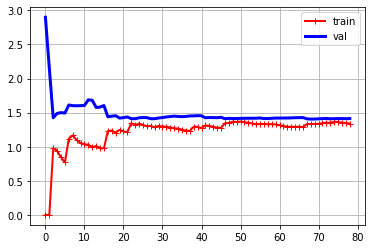

In [22]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

선형 모델은 훈련 세트에 하나 또는 두개의 샘플이 있을 때는 모델이 완벽하게 작동한다.
그러나 이후 샘플의 개수가 추가될수록 완벽하게 학습하는 것이 불가능에 가깝다.
그래서 곡선이 어느 정도 평평해질 때 까지 오차가 계속 상승한다.

> 모델이 훈련 데이터에 과소적합되어 있다면 훈련 샘플을 더 추가해도 효과가 없다.
> 더 복잡한 모델을 사용하거나 더 나은 특성을 선택해야 한다.

다음은 같은 데이터에서 10차 다항 회귀 모델의 학습 곡선이다.

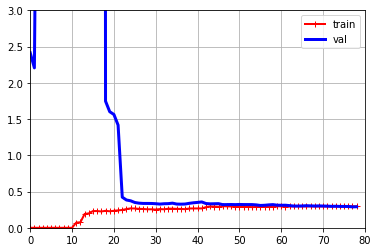

In [23]:
polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("lin_reg", LinearRegression())
])

plt.axis([0, 80, 0, 3])
plot_learning_curves(polynomial_regression, X, y)

과대적합된 모델의 학습 곡선은 이전과 비슷해 보이지만 차이가 있다.

- 훈련 데이터의 오차가 과소적합된 모델보다 훨씬 낮다.
- 두 곡선 사이에 공간이 있다. 이는 훈련 데이터에서의 모델 성능이 검증 데이터에서보다 훨씬 낫다는 뜻이다. 이는 과대적합된 모델의 특징이다.

## 4.5 규제가 있는 선형 모델
과대 적합을 감소시키는 좋은 방법은 모델을 규제하는 것이다. 모델의 자유도를 줄이면 데이터에 과대적합되기 더 어려워진다.

In [24]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

### 4.5.1 릿지 회귀
**릿지 회귀**는 규제가 추가된 선형 회귀 버전이다.

$$ J(\theta)=\mathrm{MSE}(\theta)+\alpha\frac{1}{2}\sum_{i=1}^n\theta^2_i $$

하이퍼파라미터 $\alpha$는 모델을 얼마나 많이 규제할지를 조절한다. $\alpha=0$이면 릿지 회귀는 선형 회귀와 같아진다.
$\alpha$가 매우 커지면 모든 가중치가 거의 0에 가까워지고 결국 데이터의 평균을 지나는 수평선이 된다.

아래는 선형 데이터에 몇 가지 다른 $\alpha$를 사용해 릿지 모델을 훈련시킨 결과이다.


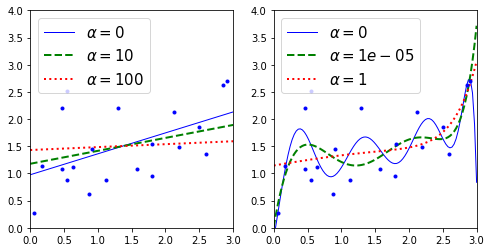

In [25]:
from sklearn.linear_model import Ridge

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

plt.show()

### 4.5.2 라쏘 회귀
라쏘 회귀는 선형 회귀의 또 다른 규제된 버전이다. 릿지 회귀처럼 비용 함수에 규제항을 더하지만,
$\mathcal{l}_2$노름의 제곱을 2로 나눈 것 대신 가중치 벡터의 $\mathcal{l}_1$노름을 사용한다.

$$ J(\theta)=\mathrm{MSE}(\theta)+\alpha\sum_{i=1}^n \left| \theta_i \right| $$

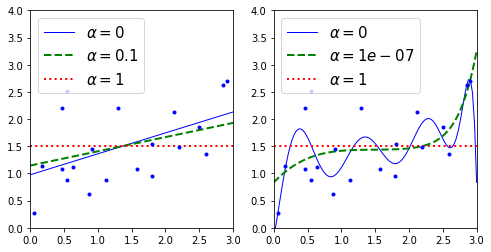

In [26]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)

plt.show()

### 4.5.3 엘라스틱넷
**엘라스틱넷**은 릿지 회귀와 라쏘 회귀를 절충한 모델이다.
규제항은 릿지와 라쏘 회귀의 규제항을 더해서 사용하며, 혼합 정도는 $r$을 사용해 조절한다.
$r=0$이면 엘라스틱넷은 릿지 회귀와 같고, $r=1$이면 라쏘 회귀와 같다.

$$ J(\theta)=\mathrm{MSE}(\theta)+r\alpha\sum_{i=1}^n \left| \theta_i \right| + \frac{1-r}{2}\alpha\sum_{i=1}^n\theta^2_i$$

### 4.5.4 조기 종료
경사 하강법과 같은 반복적인 학습 알고리즘을 규제하는 방법 중 하나는 검증 에러가 최솟값에 도달하면 바로 훈련을 중지시키는 것이다.
이를 **조기 종료**라고 한다.

## 4.6 로지스틱 회귀
어떤 회귀 알고리즘은 분류에서도 사용할 수 있다. **로지스틱 회귀**는 샘플이 특정 클래스에 속할 확률을 추정하는데 자주 사용된다.
추정 확률이 50%가 넘으면 모델은 그 샘플이 해당 클래스에 솟한다고 예측한다.

### 4.6.1 확률 추정
선형 회귀 모델과 같이 로지스틱 회귀 모델은 입력 특성의 가중치 합을 계산한다.
대신 선형 회귀처럼 값을 바로 출력하지 않고 결괏값의 **로지스틱**을 출력한다.

$$ \hat{p}=h_\theta(\mathrm{x})=\sigma(\theta^T\mathrm{x}) $$

로지스틱($\sigma(t)$)은 0과 1 사이의 값을 출력하는 시그모이드 함수이다.

$$ \sigma(t)=\frac{1}{1+e^{-t}} $$

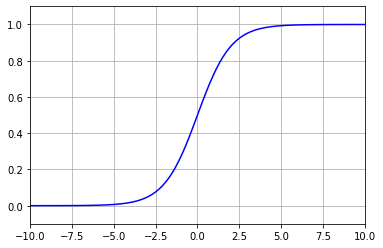

<Figure size 648x216 with 0 Axes>

In [27]:
t = np.linspace(-10, 10, 100)
y_sigmoid = 1 / (1 + np.exp(-t))
plt.plot(t, y_sigmoid, "b-")
plt.grid(True)
plt.axis([-10, 10, -0.1, 1.1])
plt.figure(figsize=(9, 3))
plt.show()

로지스틱 회귀 모델이 샘플 $\mathrm{x}$가 양성 클래스에 속할 확룰 $\hat{p}$를 추정하면 이에 대한 예측 $y$는 쉽게 구할 수 있다.

$$\hat{y}=\begin{cases}1 & \hat{p}>0.5 \\ 0 & \hat{p}\le0.5 \end{cases}$$

### 4.6.2 훈련과 비용 함수
로지스틱 회귀 모델이 어떻게 확률을 추정하고 예측하는지 알아보았다. 그렇다면 어떻게 훈련시킬 수 있을까?

$$c(\theta)=\begin{cases}-\log(\hat{p}) & y=1 \\ -\log(1-\hat{p}) & y=0 \end{cases}$$

위 비용 함수를 이용하면 모델이 양성 샘플을 0으로 예측하거나 음성 샘플을 1로 예측했을 때 비용이 증가할 것이다.
반대로  양성 샘플을 1로, 음성 샘플을 0으로 예측하면 비용이 0에 가까워질 것이다.

전체 훈련 세트에 대한 비용 함수는 모든 훈련 샘플의 비용을 평균한 것이다. 이를 하나의 식으로 쓰면 아래와 같다.

$$ J(\theta)= -\frac{1}{m} \sum_{i=1}^m \left[ y^{(i)}\log(\hat{p}^{(i)}) +(1-y^{(i)})\log(1-\hat{p}^{(i)}) \right] $$

이 비용함수는 정규방정식과 같이 최솟값을 계산하는 알려진 해가 존재하지는 않지만, 볼록함수기 때문에 경사 하강법 등을 사용할 수 있다.

### 4.6.3 결정 경계
로지스틱 회귀를 설명하기 위해 붓꽃 데이터셋을 사용한다.

In [28]:
from sklearn import datasets

iris = datasets.load_iris()
print(list(iris.keys()))

X = iris["data"][:, 3:]
y = (iris["target"] == 2).astype(np.int)

['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename']


로지스틱 회귀 모델을 훈련시키고, 꽃잎의 너비가 0~3cm인 꽃에 대해 모델의 추정 확률을 계산한다.

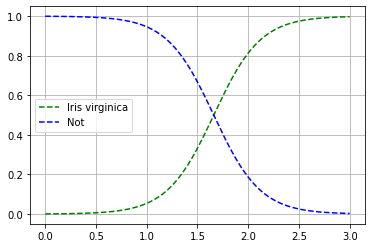

In [29]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)

X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)

plt.plot(X_new, y_proba[:, 1], "g--", label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", label="Not")
plt.grid(True)
plt.legend(loc="center left")

Iris-Verginica의 꽃잎 너비는 1.4~2.5cm에 분포한다. 반면 다른 붓꽃은 일반적으로 0.1~1.8cm에 분포한다.
입력이 2.0cm 이상이면 확실히 Iris-Verginica라고 판단할 수 있고, 반대로 1.0cm 이하의 입력은 확실히 Iris-Verginica가 아니라고 판단할 수 있다.

그런데 1.0과 2.0cm 사이의 입력이 들어오면 어떻게 될까? 양쪽 확률이 50%가 되는 약 1.6cm 근방에 결정 경계가 만들어질 것이다.

In [30]:
log_reg.predict([[0.9], [1.5], [1.7], [2.1]])

array([0, 0, 1, 1])

### 4.6.4 소프트맥스 회귀
**소프트맥스 회귀**는 로지스틱 회귀가 다중 클래스를 분류할 수 있도록 일반화한 것이다. 샘플 $\mathrm{x}$가 주어지면,
먼저 소프트맥스 회귀 모델이 각 클래스 $k$에 대한 점수 $s_k(\mathrm{x})$를 계산하고,
그 점수에 소프트맥스 함수를 적용하여 각 클래스의 확률을 추정한다.

$$ s_k(\mathrm{x})=(\theta^{(k)})^T\mathrm{x} $$

In [31]:
X = iris["data"][:, (2, 3)]
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial')

꽃잎의 길이가 5cm, 너비가 2cm인 붓꽆을 발견했다고 가정하고 이 붓꽃의 품종이 무엇인지 모델에 질의하면
높은 확률로 Iris-Virginica(클래스 2)라고 할 것이다.

In [32]:
softmax_reg.predict([[5, 2]])

array([2])